# Replicating a ViT architecture

In [66]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
from tqdm import tqdm
from collections import defaultdict
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [76]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [77]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block."""
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)# Normalize
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [78]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim) # Normalize
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # batch dimension position

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [80]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [81]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension
        # 1. Create patch embedding
        x = self.patch_embedding(x)

        # 2. Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # 3. Add position embedding to patch embedding
        x = self.position_embedding + x

        # 4. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 5. Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)

        # 6. Put 0 index logit through classifier
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [82]:
vit_base = ViT(patch_size = 16)
vit_base_pretrained = vit_b_16(weights='DEFAULT')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
# Let's setup our pretrained model
summary(model=vit_base_pretrained,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [35]:
for param in vit_base_pretrained.parameters(): # Freeze trainable parameters
  param.requires_grad = False
vit_base_pretrained.heads = nn.Sequential(
    nn.Linear(in_features = 768,
              out_features = 3)
).to(device)

In [36]:
# Take a look once again
summary(model=vit_base_pretrained,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [40]:
# Data preprocessing
import requests
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
import os
data_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
image_path.mkdir(parents=True, exist_ok=True)
target_file = Path(data_url).name
with open(data_path / target_file, "wb") as file:
  request = requests.get(data_url)
  file.write(request.content)
with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
  zip_ref.extractall(image_path)
os.remove(data_path / target_file)

In [50]:
train_path = image_path / "train"
test_path = image_path / "test"
train_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(), # / 255.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(), # / 255.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_data = datasets.ImageFolder(root=train_path,
                                  transform=train_data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

In [56]:
classes = train_data.classes
train_loader = DataLoader(dataset=train_data,
                          batch_size=32,
                          num_workers=os.cpu_count(),
                          shuffle=True)
test_loader = DataLoader(dataset=test_data,
                         batch_size=32,
                         num_workers=os.cpu_count())

In [62]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [63]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_base_pretrained.parameters(), lr = 1e-3,
                             weight_decay = 0.03)
epochs = 5

In [64]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [67]:
results = defaultdict(list)
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(vit_base_pretrained,
             train_loader,
             loss_fn,
             optimizer)
  test_loss, test_acc = test_step(vit_base_pretrained,
             test_loader,
             loss_fn)
  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)

100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


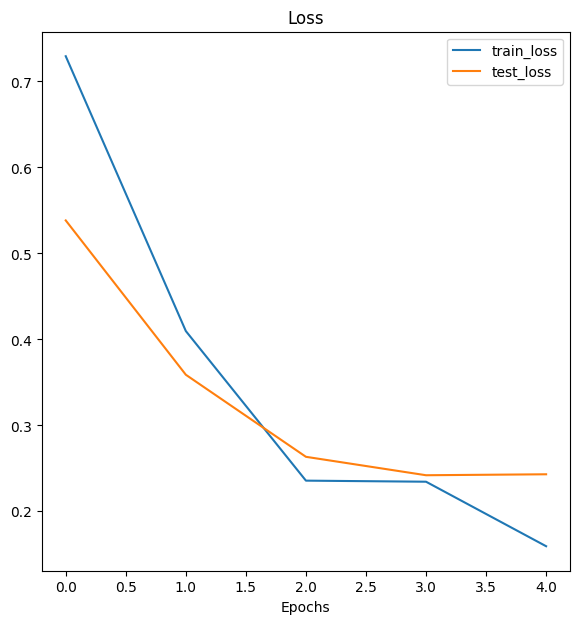

In [68]:
# Plotting
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label = "train_loss")
plt.plot(range(epochs), results["test_loss"], label = "test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

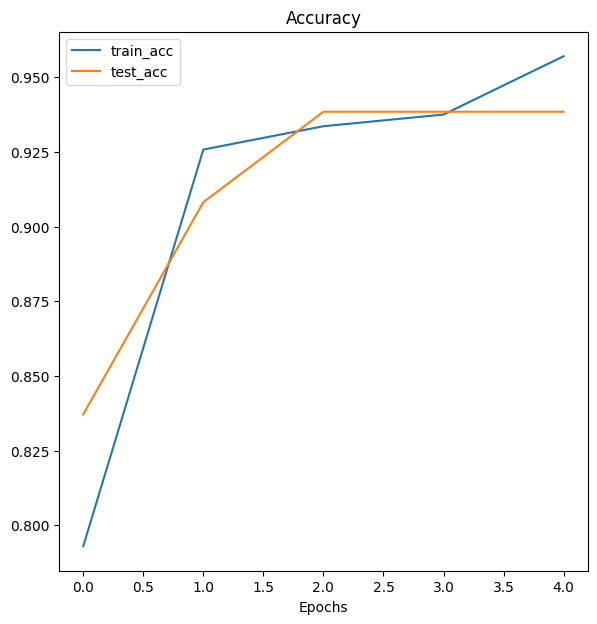

In [69]:
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_acc"], label = "train_acc")
plt.plot(range(epochs), results["test_acc"], label = "test_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Let's check whether a non-pretrained vit-base model may give such a performance on our small data sample or not.


In [ ]:
epochs = 20 # since the model isn't trained at all, we definitely need more time for training.
optimizer = torch.optim.Adam(vit_base.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()
results = defaultdict(list)
vit_base.to(device)

In [85]:
summary(model=vit_base,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [84]:
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(vit_base,
             train_loader,
             loss_fn,
             optimizer)
  test_loss, test_acc = test_step(vit_base,
             test_loader,
             loss_fn)
  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)

100%|██████████| 20/20 [03:05<00:00,  9.27s/it]


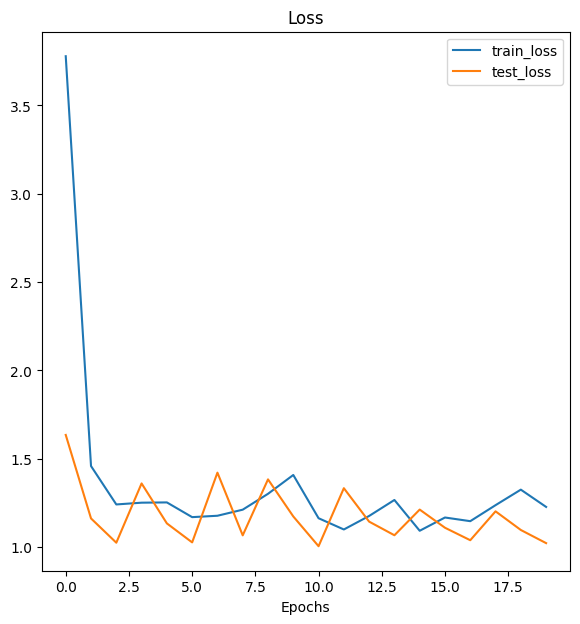

In [86]:
# Plotting
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label = "train_loss")
plt.plot(range(epochs), results["test_loss"], label = "test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

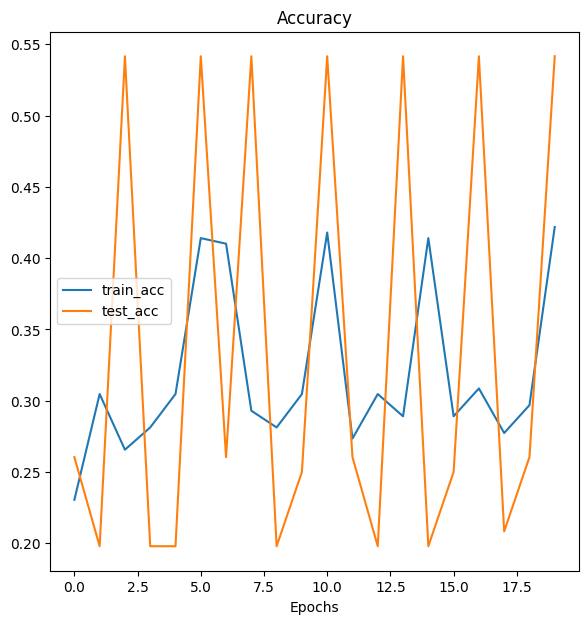

In [87]:
# Plotting
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_acc"], label = "train_acc")
plt.plot(range(epochs), results["test_acc"], label = "test_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Ekhmm.